In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## MODELING: Exploring the random forest regressor and classifier to predict price
first we read in the data, and also make the classifier target list 'rise_lower' from our existing data frame

In [3]:
df_ultra_mega_frame = pd.read_csv('../1)DATA/df_ultra_mega_frame1.csv')
df_ultra_mega_frame['date'] = pd.to_datetime(df_ultra_mega_frame['date'],infer_datetime_format=True)
df_ultra_mega_frame.index = df_ultra_mega_frame['date']
#df_ultra_mega_classifier = df_ultra_mega_frame #starting here

Below we create 'rise_fall_list' for ethereum that will be inserted back into the dataframe to be used as a feature in the classifier model. We later do this for the other selected features as well. The features we selected were Bitcoin price, Dow Jones Index and google search frequency. Sentiment was included originally but it was deemed to return an "importance value" too close to zero to be considered more useful than unuseful to the model due to the curse of dimensionality.

In [4]:
price_list = df_ultra_mega_frame['price_eth']
rise_fall_list = []

for index, item in enumerate(df_ultra_mega_frame['price_eth']):
    if df_ultra_mega_frame['price_eth'].iloc[index-1] < df_ultra_mega_frame['price_eth'].iloc[index]:
        rise_fall_list.append(1)
    else:
        rise_fall_list.append(0)
        
df_ultra_mega_frame['rise_lower'] = rise_fall_list
#df_ultra_mega_classifier = df_ultra_mega_classifier['2017-11-17':]

In [5]:
df_ultra_mega_frame.head()

,date,SearchFrequency,DJI,price_btc,price_eth,sentiment,rise_lower
date,,,,,,,
2017-11-16,2017-11-16,55,23458.359375,7871.69,330.92,0.089579,0
2017-11-17,2017-11-17,75,23358.240234,7708.99,332.39,0.087821,1
2017-11-18,2017-11-18,103,23358.240234,7790.15,347.61,0.092867,1
2017-11-19,2017-11-19,65,23358.240234,8036.49,354.39,0.092423,1
2017-11-20,2017-11-20,96,23430.330078,8200.64,366.73,0.093611,1


### Random Forest Regressor 
Here below we convert our y (being the target variable or label by formalism) to a numpy array

In [6]:
# Feature Scaling

df_scaled = df_ultra_mega_frame.copy(deep=True)

sc_x = StandardScaler()
df_scaled['price_btc'] = sc_x.fit_transform(df_scaled['price_btc'].values.reshape(-1,1))
df_scaled['price_eth'] = sc_x.fit_transform(df_scaled['price_eth'].values.reshape(-1,1))
df_scaled['sentiment'] = sc_x.fit_transform(df_scaled['sentiment'].values.reshape(-1,1))
df_scaled['DJI'] = sc_x.fit_transform(df_scaled['DJI'].values.reshape(-1,1))
df_scaled['SearchFrequency'] = sc_x.fit_transform(df_scaled['SearchFrequency'].values.reshape(-1,1))


/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
y = np.array(df_scaled['price_eth'])
# Remove the labels from the features
# axis 1 refers to the columns
features= df_scaled.drop(['price_eth','date','rise_lower'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns) #this way we remeber the column names
# Convert to numpy array
X = np.array(features) #because once we convert to np array it drops the names

At this point it's a good moment to to check X.shape and y.shape to make sure our y array is one dimensional and our X array is an 'nd array' with n corresponding to the number of features.

In [8]:
#X.shape
#y.shape 

Now we perform our test train split

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

And here we instantiate our Random Forest regressor. We first pick max_depth=2 and random_state=0 to begin with and then we later perform a Cv grid search to optimize the parameters.

In [10]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Below we print out our feature importancce values to give us an idea of which feature is the most important to our model. Here we note that any features that go to zero would be considered to not play any role in improving our model. There are two features that are close to zero but still non-zero, so they technically are still marginally improving our model.

In [11]:
print(regr.feature_importances_) #strength of importance of feature in the model
#but is using the other two because they are not zero!!!

[ 0.01590281  0.93945925  0.04004606  0.00459188]


We originally had input a feature column of the polarity score of Ethereum sentiment for each day (all reddit data that was scraped) and then this feature went to zero so we chose not to include it in our model.

when you have more features, you are basically saying you need more data to adequetly sample the space or else you run into the curse of dimensionality. This is what tells you that for the more dimenions you have, you need more data in total in order to sample your entire space. What do you run the risk of otherwise? of being innaccurate. in which way? in the way that your data set you have doesnt adequatley cover sample space.

In [12]:
print(regr.predict(X_test)) #predict y given x test

[ 1.29840676 -0.66727805  0.22906285  1.1913303   0.22906285  1.1913303
 -0.07214238  0.55813377  0.14497076 -0.07214238 -1.37903784  0.14497076
 -0.07214238 -0.07214238  0.5724353  -0.73404195  0.35170081 -1.3250675
  0.77886826 -1.2583036  -0.07214238 -0.15974958  1.1913303  -1.45561619
  0.77886826 -0.07214238  1.1913303  -1.1914769  -0.07214238 -0.07214238
 -0.07214238 -0.57372288]


As seen above: X_test is the argument taken in, but the output for the predict function is only one dimension just like y. We can later graph this result from predict against Y test to explicitly see if our model worked.

In [13]:
#now can compare with the original X and Y_train!!!
#using score 
regr.score(X_test, Y_test) #X_test , as seen above...X_test has more dimensions than the output on predict

0.80258782274634322

This score returns an r squared value. It is a percentage, how well the variablity of your data is captured by a given model comparisons betweeen different models scores tells you which model is better.

below we perform a CV grid search across the following parameters: "criterion": ["mse", "mae"], "max_depth": [2, 6, 8], "n_estimators":[50, 100, 200], and we optimize our score based off of the grid search. We also see that we perporm a cross validation of 5.

In [14]:
#use a grid search
param_grid = {"criterion": ["mse", "mae"], #mean squared error and mean absolute error in documentation
              #"min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "n_estimators":[50, 100, 200]
              #"min_samples_leaf": [20, 40, 100],
              #"max_leaf_nodes": [5, 20, 100, 500, 800],
              }

grid_cv_regr = GridSearchCV(regr, param_grid, cv=5)

grid_cv_regr.fit(X_train, Y_train) #features and labels

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
print("R-Squared::{}".format(grid_cv_regr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_regr.best_params_))

#random forest builds multiple decision trees 
#best number of decision trees
#depth of each tree shouldnt be more than 8 levels
#go down to 8 levels(splits) but dont split it further

R-Squared::0.7548945638451127
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 8, 'n_estimators': 200}


How is it that after the hyperparameter tuning, our R squared went down? difference between rsquared is that this one tells how well did this model work for hyperparametrization on the train data, because we dont give it the test data. You don't want any part of you model to be trained on the test data. So this part is NOT the same R squared from our score output.

In [16]:
df = pd.DataFrame(data=grid_cv_regr.cv_results_)
df.head()

/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Alexandra/anacond

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.048487,0.002198,0.633243,0.780480,mse,2,50,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",15,0.617288,...,0.446965,0.805065,0.646998,0.759603,0.675887,0.793992,0.008870,0.000354,0.109012,0.016837
1,0.088055,0.003461,0.639052,0.785303,mse,2,100,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",14,0.635662,...,0.448929,0.807839,0.651251,0.764959,0.672122,0.798328,0.007767,0.000029,0.109977,0.016207
2,0.169228,0.006827,0.643440,0.785800,mse,2,200,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",13,0.652159,...,0.458513,0.809231,0.651452,0.767872,0.666161,0.795866,0.004291,0.000373,0.106713,0.015444
3,0.045049,0.002045,0.748246,0.961144,mse,6,50,"{'criterion': 'mse', 'max_depth': 6, 'n_estima...",6,0.806165,...,0.518036,0.968007,0.814592,0.962139,0.758418,0.955782,0.000917,0.000099,0.119057,0.003999
4,0.087269,0.003795,0.749679,0.962400,mse,6,100,"{'criterion': 'mse', 'max_depth': 6, 'n_estima...",5,0.807294,...,0.509267,0.969506,0.812501,0.961467,0.758523,0.955926,0.001709,0.000194,0.125234,0.004363


In [17]:
results = grid_cv_regr.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))
    
#the highest is n=100, and mx depth 8 

{'criterion': 'mse', 'max_depth': 2, 'n_estimators': 50} 0.6332 0.109
{'criterion': 'mse', 'max_depth': 2, 'n_estimators': 100} 0.6391 0.11
{'criterion': 'mse', 'max_depth': 2, 'n_estimators': 200} 0.6434 0.1067
{'criterion': 'mse', 'max_depth': 6, 'n_estimators': 50} 0.7482 0.1191
{'criterion': 'mse', 'max_depth': 6, 'n_estimators': 100} 0.7497 0.1252
{'criterion': 'mse', 'max_depth': 6, 'n_estimators': 200} 0.754 0.1187
{'criterion': 'mse', 'max_depth': 8, 'n_estimators': 50} 0.751 0.1158
{'criterion': 'mse', 'max_depth': 8, 'n_estimators': 100} 0.7498 0.1262
{'criterion': 'mse', 'max_depth': 8, 'n_estimators': 200} 0.7549 0.1193
{'criterion': 'mae', 'max_depth': 2, 'n_estimators': 50} 0.5836 0.1616
{'criterion': 'mae', 'max_depth': 2, 'n_estimators': 100} 0.5973 0.1592
{'criterion': 'mae', 'max_depth': 2, 'n_estimators': 200} 0.598 0.1681
{'criterion': 'mae', 'max_depth': 6, 'n_estimators': 50} 0.7102 0.1704
{'criterion': 'mae', 'max_depth': 6, 'n_estimators': 100} 0.7181 0.1701
{'c

In [18]:
grid_cv_regr.score(X_test, Y_test) #this is really great!!!

0.92367438226966869

This was a good score! since the feature of 'sentiment' was so close to zero, lets see if removing the feasture improves the accuracy of the model! 

## Now compare to dropping a feature

In [19]:
y = np.array(df_scaled['price_eth'])
# Remove the labels from the features
# axis 1 refers to the columns
features= df_scaled.drop(['price_eth','date','rise_lower','sentiment'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns) #this way we remeber the column names
# Convert to numpy array
X = np.array(features) #because once we convert to np array it drops the names

In [20]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [21]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [22]:
print(regr.feature_importances_) #strength of importance of feature in the model
#but is using the other two because they are not zero!!!

[ 0.01590281  0.94405113  0.04004606]


In [23]:
print(regr.predict(X_test)) #predict y given x test

[ 1.29840676 -0.67951349  0.22906285  1.1913303   0.22906285  1.1913303
 -0.07214238  0.55813377  0.14497076 -0.07214238 -1.39635725  0.14497076
 -0.07214238 -0.07214238  0.5724353  -0.67951349  0.35170081 -1.3423869
  0.77886826 -1.3423869  -0.07214238 -0.15974958  1.1913303  -1.4729356
  0.77886826 -0.07214238  1.1913303  -1.13694844 -0.07214238 -0.07214238
 -0.07214238 -0.58595832]


In [24]:
#now can compare with the original X_train!!!
#using score 
regr.score(X_test, Y_test) #X_test , as seen above...X_test has more dimensions than the output on predict

0.8017445780922452

In [25]:
#use a grid search
param_grid = {"criterion": ["mse", "mae"], #mean squared error and mean absolute error in documentation
              #"min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "n_estimators":[50, 100, 200]
              #"min_samples_leaf": [20, 40, 100],
              #"max_leaf_nodes": [5, 20, 100, 500, 800],
              }

grid_cv_regr = GridSearchCV(regr, param_grid, cv=5)

grid_cv_regr.fit(X_train, Y_train) #features and labels

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
grid_cv_regr.predict(X_test) 

array([ 1.34732078, -1.10077371,  0.15225588,  1.04102542,  0.54279816,
        0.95300051, -0.28442067,  1.13001283, -0.08909218, -0.1545077 ,
       -1.48859989,  0.46508354, -0.03371684, -0.00196058,  0.58260302,
       -1.20496377,  0.67904536, -1.26801797,  1.54458964, -1.3035733 ,
       -0.09655548, -0.20795975,  1.02504117, -1.48727896,  1.5853497 ,
       -0.14698618,  1.0072227 , -1.33368201,  0.16739109, -0.52264231,
       -0.09228813, -1.12636684])

We check the output and notice that its one dimensional which is what we want. We now set this variable to Y_predicted so that we can later graph it against Y_test.

In [27]:
Y_predicted = grid_cv_regr.predict(X_test)

In [28]:
print("R-Squared::{}".format(grid_cv_regr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_regr.best_params_))

#random forest builds multiple decision trees 
#best number of decision trees
#depth of each tree shouldnt be more than 8 levels
#go down to 8 levels(splits) but dont split it further

R-Squared::0.7797755498836152
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 8, 'n_estimators': 100}


In [29]:
df = pd.DataFrame(data=grid_cv_regr.cv_results_)
df.head()

/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Alexandra/anacond

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.051294,0.002151,0.635147,0.778980,mse,2,50,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",15,0.614212,...,0.450696,0.803998,0.656762,0.758853,0.675603,0.792493,0.010318,0.000283,0.107932,0.016908
1,0.084340,0.003847,0.641909,0.783677,mse,2,100,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",14,0.632573,...,0.450889,0.807285,0.661534,0.762090,0.677862,0.795574,0.003710,0.000417,0.109848,0.016572
2,0.173179,0.007047,0.644673,0.783179,mse,2,200,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",13,0.646722,...,0.453440,0.809010,0.663916,0.762463,0.673048,0.792382,0.012647,0.000881,0.108437,0.016650
3,0.043909,0.002241,0.772992,0.966542,mse,6,50,"{'criterion': 'mse', 'max_depth': 6, 'n_estima...",6,0.776002,...,0.534217,0.973138,0.833173,0.969704,0.827960,0.963136,0.001836,0.000372,0.126173,0.004176
4,0.088370,0.004095,0.779517,0.967336,mse,6,100,"{'criterion': 'mse', 'max_depth': 6, 'n_estima...",2,0.775295,...,0.534746,0.972878,0.842237,0.968291,0.846299,0.964258,0.005556,0.000778,0.129696,0.003175


In [30]:
results = grid_cv_regr.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))
    
#the highest is n=100, and mx depth 8 

{'criterion': 'mse', 'max_depth': 2, 'n_estimators': 50} 0.6351 0.1079
{'criterion': 'mse', 'max_depth': 2, 'n_estimators': 100} 0.6419 0.1098
{'criterion': 'mse', 'max_depth': 2, 'n_estimators': 200} 0.6447 0.1084
{'criterion': 'mse', 'max_depth': 6, 'n_estimators': 50} 0.773 0.1262
{'criterion': 'mse', 'max_depth': 6, 'n_estimators': 100} 0.7795 0.1297
{'criterion': 'mse', 'max_depth': 6, 'n_estimators': 200} 0.776 0.1279
{'criterion': 'mse', 'max_depth': 8, 'n_estimators': 50} 0.7753 0.1273
{'criterion': 'mse', 'max_depth': 8, 'n_estimators': 100} 0.7798 0.1331
{'criterion': 'mse', 'max_depth': 8, 'n_estimators': 200} 0.7775 0.1307
{'criterion': 'mae', 'max_depth': 2, 'n_estimators': 50} 0.589 0.1616
{'criterion': 'mae', 'max_depth': 2, 'n_estimators': 100} 0.6 0.1608
{'criterion': 'mae', 'max_depth': 2, 'n_estimators': 200} 0.6016 0.1702
{'criterion': 'mae', 'max_depth': 6, 'n_estimators': 50} 0.7343 0.1623
{'criterion': 'mae', 'max_depth': 6, 'n_estimators': 100} 0.7366 0.1553
{'c

In [31]:
grid_cv_regr.score(X_test, Y_test) #this is really great!!!

0.94480712245706144

From here we see that hyperparameterization worked!!

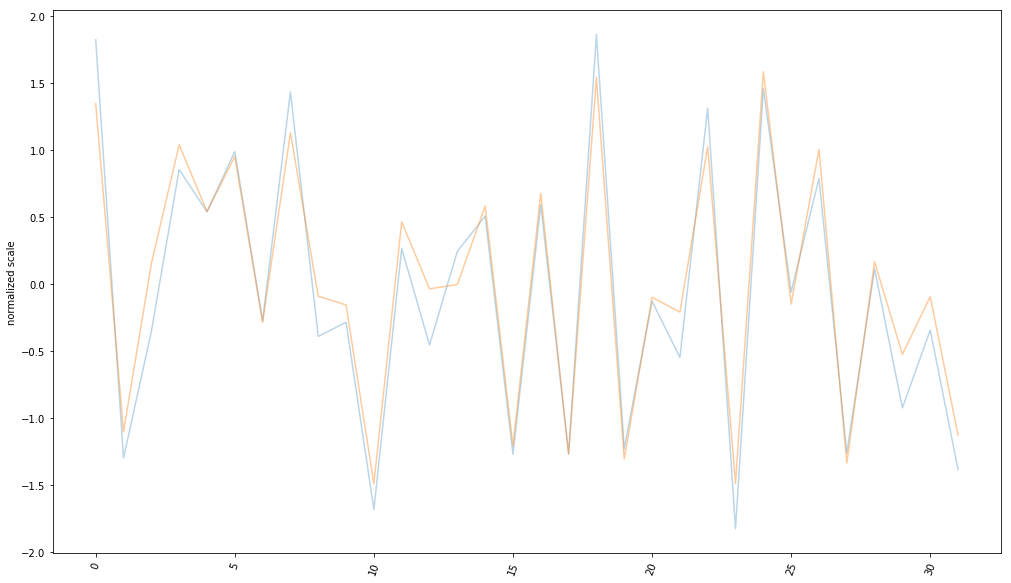

In [32]:
plt.figure(figsize=(17, 10))
plt.plot(Y_test, alpha = 0.3)
plt.plot(Y_predicted, alpha = 0.4)

# need to add legend
plt.ylabel('normalized scale')
plt.xticks(rotation=70)
plt.show()

grid_cv_regr.score(X_test, Y_test), performs the same thing, (notice the number is the same) it runs the model again with the optimized parameters

Note: this doesn't forcast what is to come. This model tells us How changes in the Dow Jones (and other features) might cause changes in ethereum. If you can use Time series analysis to forecast changes in the dow jones, you might be able to predict changes in ethereum, but you dont have the ability to do forecasting with this model.

Can A Regression model forecast? The most you can forcast Is If you predicted dow jones values and fed that prediction into a model to forcast ethereum price. Dow jones index has a lot of historical data backing it up as opposed to etheruem, so thats why it could posible be used as an exogeneous variable in a time series model (ARIMAX was looked into breifly for this prroject and more will be included on that.

A classification model can be put into place in order to predict if the price of ethereum will go up or down. In order to do this all of the features that are deemed significant must also be converted to a binary list of 0's or 1's. A 0 signifying that the price dropped since the day before and a 1 signifying that the price rose since then.

We will now look at classification and for this we weill drop the sentiment feature.

### now for classification 

In [33]:
y = df_scaled['rise_lower']

In [34]:
y = np.array(df_scaled['rise_lower'])
# Remove the labels from the features
# axis 1 refers to the columns
features= df_scaled.drop(['date','rise_lower','price_eth','sentiment'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns) #this way we remeber the column names
# Convert to numpy array
X = np.array(features) #because once we convert to np array it drops the names

In [35]:
#features #toggle this to double check

In [59]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [60]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [61]:
clf.feature_importances_

array([0.28857295, 0.24358315, 0.46784389])

In [62]:
#features

In [63]:
clf.predict(X_test)

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1])

In [64]:
clf.score(X_test, Y_test)

0.59375

In [65]:
#use a grid search

param_grid = {#"criterion": ["mse", "mae"], #mean squared error and mean absolute error in documentation
              #"min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "n_estimators":[50, 100, 200]
              #"min_samples_leaf": [20, 40, 100],
              #"max_leaf_nodes": [5, 20, 100, 500, 800],
              }

grid_cv_clf = GridSearchCV(clf, param_grid, cv=5)
grid_cv_clf.fit(X_train, Y_train) #features and labels

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 6, 8], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [66]:
print("R-Squared::{}".format(grid_cv_regr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_regr.best_params_))

#random forest builds multiple decision trees 
#best number of decision trees
#depth of each tree shouldnt be more than 8 levels
#go down to 8 levels(splits) but dont split it further

R-Squared::0.7797755498836152
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 8, 'n_estimators': 100}


In [67]:
df = pd.DataFrame(data=grid_cv_regr.cv_results_)
df.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.042540,0.002584,0.635147,0.778980,mse,2,50,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",15,0.614212,...,0.450696,0.803998,0.656762,0.758853,0.675603,0.792493,0.004989,0.000234,0.107932,0.016908
1,0.080937,0.004915,0.641909,0.783677,mse,2,100,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",14,0.632573,...,0.450889,0.807285,0.661534,0.762090,0.677862,0.795574,0.006396,0.000734,0.109848,0.016572
2,0.160024,0.008687,0.644673,0.783179,mse,2,200,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",13,0.646722,...,0.453440,0.809010,0.663916,0.762463,0.673048,0.792382,0.011674,0.000278,0.108437,0.016650
3,0.041521,0.002519,0.772992,0.966542,mse,6,50,"{'criterion': 'mse', 'max_depth': 6, 'n_estima...",6,0.776002,...,0.534217,0.973138,0.833173,0.969704,0.827960,0.963136,0.001249,0.000043,0.126173,0.004176
4,0.082450,0.005063,0.779517,0.967336,mse,6,100,"{'criterion': 'mse', 'max_depth': 6, 'n_estima...",2,0.775295,...,0.534746,0.972878,0.842237,0.968291,0.846299,0.964258,0.003932,0.001008,0.129696,0.003175


In [68]:
grid_cv_clf.score(X_test, Y_test)

0.46875

It feels as if what we did here was comparing apples and oranges. Comparing apples with apples would be more like, did dow jones increase? did google search frequency increase? a score around 50 percent is actually a likely result here, because this is a binary target, and nothing in my features say anything about the previous day. Here we are taking a bunch of values and trying to figure out weather these values were higher or lower than the previous day, but we have no information about the previous day in our dfeatures matrix. For example when looking at one line of data from our features matrix, does any cell in this line tell us something about the previous day? On any given line how does it compare to the one before it? All these values are independent from the day before, acording to my model, because we are not saying how they are related.

Now we will explore another idea for a classifier. For every single feature, make it an up or down binary vector. We should get way better results because we are not simply flipping a coin anymore. The binary of dow jones having gone up or down up or down should be more predictive.

### Classification with binary features:
first we will make some binary features from lists utilizing the enumerate function. What the binary representation will indicate is the following: if the value went up from the day before we will attribute a 1 to that value. Each element in the vector is saying something about what direction price went from the day before.

In [69]:
rise_fall_list_DJI = []

for index, item in enumerate(df_ultra_mega_frame['DJI']):
    if df_ultra_mega_frame['DJI'].iloc[index-1] < df_ultra_mega_frame['DJI'].iloc[index]:
        rise_fall_list_DJI.append(1)
    else:
        rise_fall_list_DJI.append(0)
        

df_ultra_mega_frame['rise_lower_dji'] = rise_fall_list_DJI

#--------
rise_fall_list_BTC = []

for index, item in enumerate(df_ultra_mega_frame['price_btc']):
    if df_ultra_mega_frame['price_btc'].iloc[index-1] < df_ultra_mega_frame['price_btc'].iloc[index]:
        rise_fall_list_BTC.append(1)
    else:
        rise_fall_list_BTC.append(0)
        

df_ultra_mega_frame['rise_lower_btc'] = rise_fall_list_BTC

#---------
rise_fall_list_SF = []

for index, item in enumerate(df_ultra_mega_frame['SearchFrequency']):
    if df_ultra_mega_frame['SearchFrequency'].iloc[index-1] < df_ultra_mega_frame['SearchFrequency'].iloc[index]:
        rise_fall_list_SF.append(1)
    else:
        rise_fall_list_SF.append(0)
        

df_ultra_mega_frame['rise_lower_sf'] = rise_fall_list_SF

df_ultra_mega_frame = df_ultra_mega_frame['2017-11-17':]

Note that at the bottom of this code block we chop off the first line of the data frame because at this pint we are only dealing with the binary features and we do not have information to say whether the first element of our data set rose in price or fell in price.

In [70]:
y = df_ultra_mega_frame['rise_lower'] #setting our label y

In [71]:
y = np.array(df_ultra_mega_frame['rise_lower'])
# Remove the labels from the features
# axis 1 refers to the columns
features= df_ultra_mega_frame.filter(['rise_lower_dji','rise_lower_btc','rise_lower_sf'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns) #this way we remeber the column names
# Convert to numpy array
X = np.array(features) #because once we convert to np array it drops the names

In [72]:
#features

In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [74]:
clf.feature_importances_

array([0.12937936, 0.78567976, 0.08494088])

In [75]:
clf.predict(X_test)

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0])

In [76]:
clf.score(X_test, Y_test)

0.6875

In [77]:
#use a grid search

param_grid = {#"criterion": ["mse", "mae"], #mean squared error and mean absolute error in documentation
              #"min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "n_estimators":[50, 100, 200]
              #"min_samples_leaf": [20, 40, 100],
              #"max_leaf_nodes": [5, 20, 100, 500, 800],
              }

grid_cv_clf = GridSearchCV(clf, param_grid, cv=5)

grid_cv_clf.fit(X_train, Y_train) #features and labels

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 6, 8], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [78]:
print("R-Squared::{}".format(grid_cv_regr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_regr.best_params_))

#random forest builds multiple decision trees 
#best number of decision trees
#depth of each tree shouldnt be more than 8 levels
#go down to 8 levels(splits) but dont split it further

R-Squared::0.7797755498836152
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 8, 'n_estimators': 100}


In [79]:
df = pd.DataFrame(data=grid_cv_regr.cv_results_)
df.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.042540,0.002584,0.635147,0.778980,mse,2,50,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",15,0.614212,...,0.450696,0.803998,0.656762,0.758853,0.675603,0.792493,0.004989,0.000234,0.107932,0.016908
1,0.080937,0.004915,0.641909,0.783677,mse,2,100,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",14,0.632573,...,0.450889,0.807285,0.661534,0.762090,0.677862,0.795574,0.006396,0.000734,0.109848,0.016572
2,0.160024,0.008687,0.644673,0.783179,mse,2,200,"{'criterion': 'mse', 'max_depth': 2, 'n_estima...",13,0.646722,...,0.453440,0.809010,0.663916,0.762463,0.673048,0.792382,0.011674,0.000278,0.108437,0.016650
3,0.041521,0.002519,0.772992,0.966542,mse,6,50,"{'criterion': 'mse', 'max_depth': 6, 'n_estima...",6,0.776002,...,0.534217,0.973138,0.833173,0.969704,0.827960,0.963136,0.001249,0.000043,0.126173,0.004176
4,0.082450,0.005063,0.779517,0.967336,mse,6,100,"{'criterion': 'mse', 'max_depth': 6, 'n_estima...",2,0.775295,...,0.534746,0.972878,0.842237,0.968291,0.846299,0.964258,0.003932,0.001008,0.129696,0.003175


In [80]:
grid_cv_clf.score(X_test,Y_test)

0.6875

here hyperparameterization did not improve!